In [56]:
import argparse
import json
import ssl
import datetime
import os
import math

import numpy as np
import matplotlib.pyplot as plt

from model import get_model
from triplet_loss import batch_all_triplet_loss
from data import get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet_v2 import preprocess_input

In [2]:
 with open('hyperparameters/initial_run.json', 'rb') as f:
        params = json.load(f)

In [3]:
class SiameseModel(Model):
    def __init__(self, params, finetune):
        super().__init__()
        self.params = params
        self.finetune = finetune
        self.siamese_network = get_model(params, finetune)
        self.custom_loss = batch_all_triplet_loss
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        images, labels = data
        with tf.GradientTape() as tape:
            loss = self._compute_loss(images, labels)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        images, labels = data
        loss = self._compute_loss(images, labels)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, images, labels):
        embeddings = self.siamese_network(images)
        embeddings = tf.math.l2_normalize(embeddings, axis=1, epsilon=1e-10)
        return self.custom_loss(labels, embeddings, self.params['margin'], self.params['squared'])

In [4]:
siamese_model = SiameseModel(params, True)
siamese_model.compile(optimizer=optimizers.Adam(params['lr']))

In [5]:
siamese_model.load_weights('/Users/deepakduggirala/Downloads/best_weights')

In [6]:
input_shape=(None, params['image_size'], params['image_size'], 3)
siamese_model.compute_output_shape(input_shape=input_shape)

TensorShape([None, 256])

In [7]:
siamese_model.summary()

Model: "siamese_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 256)               24089344  
                                                                 
Total params: 24,089,346
Trainable params: 9,457,920
Non-trainable params: 14,631,426
_________________________________________________________________


In [8]:
siamese_model.siamese_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
Total params: 24,089,344
Trainable params: 9,457,920
Non-trainable params: 14,631,424
_________________________________________________________________


In [9]:
def preprocess_image(image, image_size):
    image = tf.image.resize(image, [image_size, image_size])
    image = preprocess_input(image)
    return image

In [10]:
def parse_image_function(image_path, label, image_size):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = preprocess_image(image, image_size)
    return image, label

In [11]:
def get_dataset(f, params, dir_path):
    image_paths, image_labels = f(dir_path)
    N = len(image_labels)
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
    dataset = dataset.map(lambda x, y: parse_image_function(x, y, params['image_size']))
    dataset = dataset.batch(params['batch_size']).prefetch(AUTOTUNE)
    return dataset


In [12]:
# get_zoo_elephants_images_and_labels, get_ELEP_images_and_labels
tfds = get_dataset(get_ELEP_images_and_labels, params, '/Users/deepakduggirala/Documents/ELPephant-cropped')

In [13]:
embeddings=[]
all_labels = []
m = siamese_model.siamese_network
for images, labels in tfds.as_numpy_iterator():
    em = m(images)
    embeddings.append(em)
    all_labels.append(labels)

2022-04-21 14:28:28.466146: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [14]:
embeddings = tf.concat(embeddings,0)
embeddings.shape

TensorShape([2075, 256])

In [15]:
all_labels = tf.concat(all_labels, 0)
all_labels.shape

TensorShape([2075])

In [73]:
# embeddings = embeddings.numpy()
labels = all_labels.numpy()

In [23]:
unique_identities = list(set(all_labels.numpy()))

In [51]:
unique_identities[0:3]

[b'3883', b'3337', b'3480']

In [42]:
norm_emb = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=1)

In [52]:
idx = np.where((labels == b'3883') | (labels == b'3337') | (labels == b'3480'))[0]
emb_elep = norm_emb[idx]

In [80]:
pts = ['3883']*np.sum(labels == b'3883') + ['3337']*np.sum(labels == b'3337') + ['3480']*np.sum(labels == b'3480')

In [71]:
np.sum(labels == b'3883')

0

In [119]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(norm_emb)

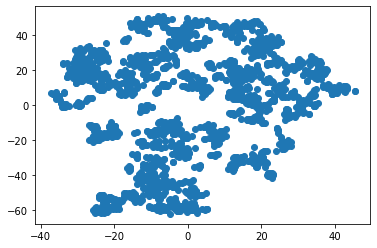

In [120]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])

# for i, label in enumerate(pts):
#     plt.annotate(label, (X_embedded[i,0], X_embedded[i,1]))




In [345]:
from sklearn.preprocessing import OrdinalEncoder
sorted_labels = labels[np.argsort(labels)]
enc = OrdinalEncoder()
enc.fit(sorted_labels.reshape(-1,1))
categories = enc.transform(sorted_labels.reshape(-1,1))
#Create mask
mask = (categories - categories.T == 0)

In [348]:
# Create Kernel Matrix
emb_sorted = norm_emb[np.argsort(labels)]
X_norm_sq = np.sum(emb_sorted**2, axis=1)
K = X_norm_sq[:,np.newaxis] + X_norm_sq[np.newaxis, :] - 2*np.dot(emb_sorted, emb_sorted.T)
N = emb_sorted.shape[0]
d = 0.5

In [349]:
def get_VAL(K, mask, d):
    TA = K[np.where(mask)] < d
    return np.sum(TA)/TA.shape[0]   

In [350]:
def get_FAR(K, mask, d):
    FA = K[np.where(~mask)] <= d
    return np.sum(FA)/FA.shape[0]

In [351]:
VAL = get_VAL(K, mask, d)
VAL

0.801545536433888

In [352]:
FAR = get_FAR(K, mask, d)
FAR

0.038278159668313834

In [353]:
def get_TP(K, mask, d):
    return np.sum(mask * (K <= d))

def get_TN(K, mask, d):
    return np.sum(~mask * (K > d))

def get_accuracy(TP, TN, N):
    return (TP+TN)/(N*N)

In [354]:
TP = get_TP(K, mask, d)
TN = get_TN(K, mask, d)
acc = get_accuracy(TP, TN, N)
TP, TN, acc

(16907, 4120528, 0.9609371461750617)

In [ ]:
# R = np.random.randint(low=0, high=2, size=(N,N)).astype(np.bool8)
# TP = np.sum(mask * R)
# TN = np.sum(~mask * R)
# (TP+TN)/(N*(N))

In [347]:
# d = 0.5
# p_same_idx = np.triu_indices(7, k = 1)
# N = p_same_idx[0].shape[0]
# np.sum(K[:7,:7][p_same_idx] < d)/N

In [342]:
# N = categories.shape[0]
# Z = np.zeros((N, N, 3), dtype=np.int32)
# X, Y = np.meshgrid(np.arange(N), np.arange(N))
# Z[:,:,0] = Y
# Z[:,:,1] = X
# Z[:,:, 2] = mask
# ix, iy = np.triu_indices(N, k = 1)

# tr_u = Z[ix, iy, :]

# same_idx = tr_u[tr_u[:,2]==1, :2]
# diff_idx = tr_u[tr_u[:,2]==0, :2]

In [296]:
# same_idx

In [293]:
# TA = K[same_idx[:,0], same_idx[:,1]] < d

# VAL = np.sum(TA)/TA.shape[0]
# VAL

In [294]:
# np.sum(TA), TA.shape[0]

In [295]:
# FA = K[diff_idx[:,0], diff_idx[:,1]] <= d

# FAR = np.sum(FA)/FA.shape[0]
# FAR

In [297]:
# np.sum(FA), FA.shape